## <center> Solutions for Ultimate Take-home Challenge <center>

In [1]:
######################
# Importing packages
######################
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
import random
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import xgboost as xgb
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

### Part 1 - Exploratory data analysis

In [3]:
#########################
# Load logins.json file
#########################
login_time=pd.read_json('logins.json')
login_time.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
bins=[login_time.iloc[0, 0]+timedelta(minutes=15)*i for i in range(2+int((login_time.iloc[-1, 0]-login_time.iloc[0, 0])/timedelta(minutes=15)))]

In [7]:
out=pd.cut(login_time['login_time'], bins=bins, include_lowest=True)
out_count=out.value_counts(sort=False)

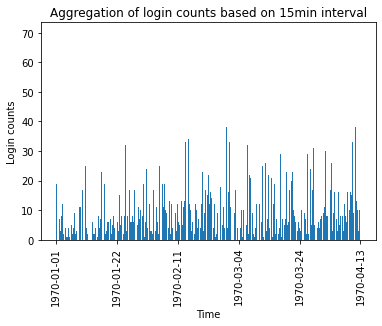

In [63]:
_=plt.bar([i for i, _ in enumerate(out_count)], out_count.values)
x_interval=(login_time.iloc[-1, 0]-login_time.iloc[0, 0])/5
x_position=[login_time.iloc[0, 0]+x_interval*i for i in range(6)]
n_position=[]
for i in range(6):
    for j, categorical_index in enumerate(out_count.index):
        if x_position[i] in categorical_index:
            n_position.append(j)
            break
x_label=[ele.strftime('%Y-%m-%d') for ele in x_position]
_=plt.xticks(n_position, x_label, rotation=90)
_=plt.xlabel('Time')
_=plt.ylabel('Login counts')
_=plt.title('Aggregation of login counts based on 15min interval')
plt.show()

It seems that the number of login has a pattern of cycles. Now I zoom in the first week of March to observe this pattern.

In [49]:
dataframe=pd.DataFrame({'categorical': [ele for ele in out_count.index]})
dataframe['start']=dataframe['categorical'].apply(lambda x: pd.to_datetime('1970-03-01', format='%Y-%m-%d') in x)
dataframe['end']=dataframe['categorical'].apply(lambda x: pd.to_datetime('1970-03-08', format='%Y-%m-%d') in x)
dataframe1=dataframe[(dataframe['start']|dataframe['end'])]
out_count_zoom_in=out_count[dataframe1.index[0]:(dataframe1.index[1]+1)]

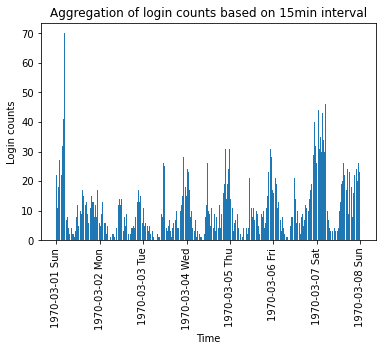

In [64]:
x_position=[pd.to_datetime('1970-03-0{}'.format(i)) for i in range(1, 9)]
n_position=[]
for i in range(8):
    for j, categorical_index in enumerate(out_count_zoom_in.index):
        if x_position[i] in categorical_index:
            n_position.append(j)
            break
x_label=[ele.strftime('%Y-%m-%d %a') for ele in x_position]
_=plt.bar([i for i, _ in enumerate(out_count_zoom_in)], out_count_zoom_in.values)
_=plt.xticks(n_position, x_label, rotation=90)
_=plt.xlabel('Time')
_=plt.ylabel('Login counts')
_=plt.title('Aggregation of login counts based on 15min interval')
plt.show()

Now the demand pattern is clear: the bigger demands always happen around midnights, especially Friday and Saturday midnights. At noon there are another wave of demands, but are not as strong as the demands in midnights.

In [62]:
out_count.sort_values().value_counts(sort=False).head()

0     403
8     493
16    218
24     86
32     22
Name: login_time, dtype: int64

There are 403 of 15 minutes time intervals that nobody was logging in. This maybe reflects the real situation, or maybe some data are missing and not included in this data set.

### Part 2 - Experiment and metrics design

#### Question 1: What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

I would choose the total trip distances of a group of drivers in certain time intervals as the metric for this study. If the trip distances can be significantly longer with the encouraging driver partners to serve both cities compared to the control group of driver partners without reimbursements, we can consider this experiment successful. 

The reason to choose this metric is because the trip distances is directly related to the commission fee: the longer the trip, the more income the company can get. The goal of this experiment is more profit for the company even after deducting the toll reimbursements.

#### Question 2: Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

#### a. How you will implement the experiment?

One proposed experiment plan can be like this: 1) the company randomly selects two groups of driver partners from both cities; 2) for A group the company reimburses the toll, and for B group the company doesn't do anything; and 3) records the total trip distance data in certain time intervals for both A and B groups during the period of test time. 

#### b. What statistical test(s) you will conduct to verify the significance of the observation?

I am going to perform an A/B test to see if reimbursing the toll can bring a higher total trip distance, resulting in higher profit. In detail, I am going to perform a two sample bootstrap hypothesis tests. The null hypothesis is that, the test statistic is impervious to the change (reimbursing the toll). 

After the experiment, I am going to have two sets of trip distance data from A and B groups. I am going to do the following: 1) calculate the total mean of all trip distances; 2) shift both data sets to have the common mean; 3) generate bootstrap replicates of the mean each for two shifted arrays; 4) calculate the difference of the means; and 5) calculate p-value to see if it is significantly small (<0.05). If p-value is significantly small (<0.05), I can reject the null hypothesis and say that the change has statistically significant impact.

#### c. How you would interpret the results and provide recommendations to the city operations team along with any caveats?

If the p-value is really small, like <0.001, it's safe to say that the impact of change is significant, but if the p-value is close to 0.05, it is hard to say that if the impact is significant or not, because the number of 0.05 itself is not significant: it is not like 0.051 is non-significant and 0.049 is suddenly becoming significant.

Another recommendation is, the company needs to perform the profit evaluation as well. Dose the new strategy bring significant income to the company, or the company is actually losing money by reimbursing the toll to the drivers? A higher income is the goal of this experiment.

### Part 3 - Predictive modeling

#### 3.1 Data Wrangling and EDA

In [6]:
######################################
# Load ultimate_data_challenge.json
######################################
data0=pd.read_json('ultimate_data_challenge.json')
data0.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [7]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There are some missing data in driver rating column, rating by driver column, and phone column. I will impute the median value if there is no rating value, and impute "other" if there is no information about the phones owned by users.

In [13]:
data1=data0.copy()
data1['avg_rating_of_driver']=data0['avg_rating_of_driver'].fillna(data0['avg_rating_of_driver'].median())
data1['phone']=data0['phone'].fillna('other')
data1['avg_rating_by_driver']=data0['avg_rating_by_driver'].fillna(data0['avg_rating_by_driver'].median())

In [24]:
################################################
# Construct dependend variables - retained
################################################
data2=data1.copy()
data2['signup_date']=data1['signup_date'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
data2['last_trip_date']=data1['last_trip_date'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
data2['retained_dates']=data2['last_trip_date']-data2['signup_date']
data2['retained']=data2['retained_dates'].apply(lambda x: 1 if x>=timedelta(days=30) else 0)
data2=data2.drop(columns=['signup_date', 'last_trip_date', 'retained_dates'])
data2.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,1
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,1


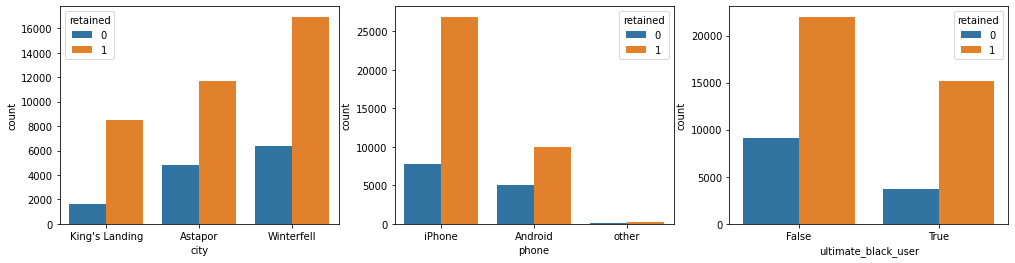

In [16]:
#####################################
# Data Visualizations - categorical
#####################################
categorical_columns=['city', 'phone', 'ultimate_black_user']
fig, (ax1, ax2, ax3)=plt.subplots(1, 3, figsize=(17, 4))
ax=[ax1, ax2, ax3]
for index, name in enumerate(categorical_columns):
    _=sns.countplot(x=name, hue='retained', data=data2, ax=ax[index])
plt.show()

It can be seen that the city of Winterfell has more users; more users are using iPhones, and more users are not ultimate black users. Also the number of retained users is much more than the number of left users. Regarding cities, the ratio is almost evenly distributed, however, more iPhone users trend to stay in service, and more ultimate black users trend to stay in services.

It seems that there is an imbalanced class problem, and we have to address and mitigate this problem during modeling.

<ipython-input-17-3c2955fbf9e5>:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  _=scatter_matrix(data2[numerical_columns], ax=ax)


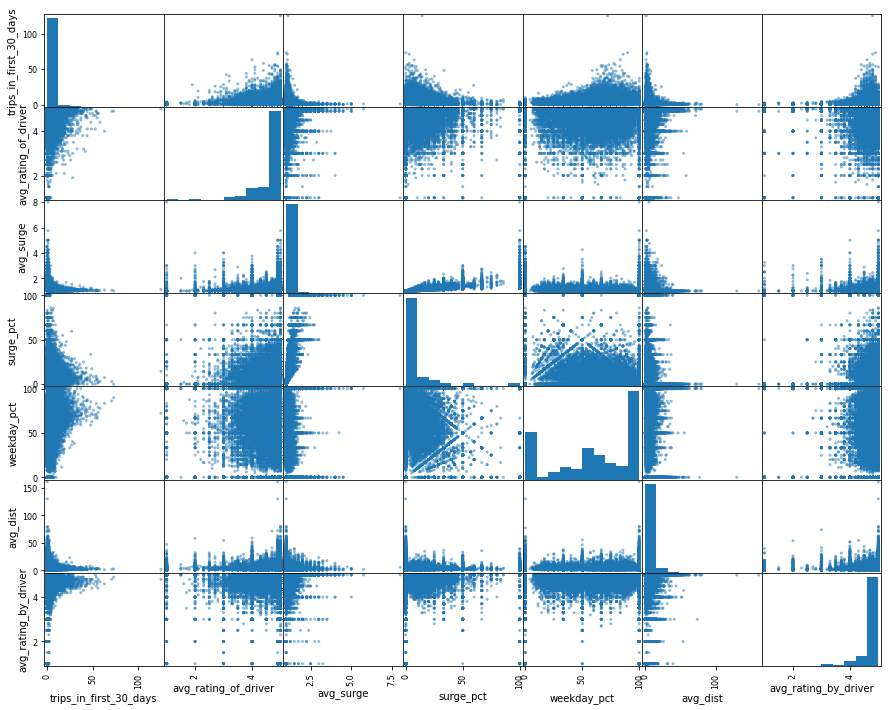

In [17]:
#####################################
# Data Visualizations - numerical
#####################################
numerical_columns=['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 
                   'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']
fig, (ax)=plt.subplots(1, 1, figsize=(15, 12))
_=scatter_matrix(data2[numerical_columns], ax=ax)
plt.show()

It can be seen that there are no obvious strong correlations between features.

In [61]:
#################################################
# Build data set for modeling, include:
#################################################
# one-hot encoding for the categorical columns
#################################################
data3=data2.copy()
categorical_columns=['city', 'phone', 'ultimate_black_user']
data3['ultimate_black_user']=data2['ultimate_black_user'].apply(lambda x: 1 if x else 0)
data4=pd.get_dummies(data3[categorical_columns])
#################################################
# Min-max scale the numerical columns
#################################################
numerical_columns=['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 
                   'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']
scaler=MinMaxScaler(feature_range=(0, 1))
for i in range(len(numerical_columns)):
    data4[numerical_columns[i]]=\
    [ele2[0] for ele2 in scaler.fit_transform([[ele] for ele in data3[numerical_columns].iloc[:, i].values])]
data4['retained']=data3['retained']
data4.head()

,ultimate_black_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,1,0,1,0,0,1,0,0.032,0.925,0.014286,0.154,0.462,0.022801,1.000,1
1,0,1,0,0,1,0,0,0.000,1.000,0.000000,0.000,0.500,0.051317,1.000,1
2,0,1,0,0,0,1,0,0.024,0.825,0.000000,0.000,1.000,0.004784,1.000,0
3,1,0,1,0,0,1,0,0.072,0.900,0.020000,0.200,0.800,0.014662,0.975,1
4,0,0,0,1,1,0,0,0.112,0.850,0.027143,0.118,0.824,0.019446,0.975,1


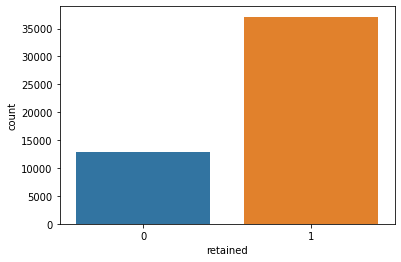

In [62]:
_=sns.countplot(x='retained', data=data4)
plt.show()

In [63]:
data4['retained'].value_counts()

1    37129
0    12871
Name: retained, dtype: int64

There is an imbalance class problem of this data set: the number of retained users is twice more than the left users. If I directly use this data set for modeling, the right answer could be hard to find, because by simply saying that everybody is retained user, I could get as high as 74% accuracy. I am going to randomly delete some retained users to make the two classes balance.  

In [77]:
random.seed(0)
data=data4[data4['retained']==1].sample(n=12871).append(data4[data4['retained']==0]).sample(frac=1)
data.head()

,ultimate_black_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained
34934,0,0,0,1,1,0,0,0.000,0.875,0.000000,0.000,1.000,0.070452,1.000,1
39017,0,0,1,0,1,0,0,0.008,0.975,0.000000,0.000,0.000,0.014414,1.000,0
43499,1,0,0,1,0,1,0,0.008,1.000,0.000000,0.000,0.125,0.013792,0.875,1
17279,0,0,0,1,0,1,0,0.032,0.950,0.018571,0.214,0.357,0.017023,0.975,1
7836,1,1,0,0,0,1,0,0.008,1.000,0.000000,0.000,0.000,0.014476,1.000,0


In [83]:
##############################################
# Save clean data
##############################################
X_train, X_test, y_train, y_test=train_test_split(data.drop(columns=['retained']), data.retained, test_size=0.3)
with open('clean_data.pkl', 'wb') as file:
    pickle.dump(data, file)
    pickle.dump(X_train, file)
    pickle.dump(X_test, file)
    pickle.dump(y_train, file)
    pickle.dump(y_test, file)
##############################################

#### 3.2 Build Predictive Models

In [2]:
###############################################
# Load clean data
###############################################
with open('clean_data.pkl', 'rb') as file:
    data=pickle.load(file)
    X_train=pickle.load(file)
    X_test=pickle.load(file)
    y_train=pickle.load(file)
    y_test=pickle.load(file)
###############################################
kfold=KFold(n_splits=5, shuffle=True, random_state=37)

##### 3.2.1 Random Forest

Random Forests algorithm is famious because of its accuracy and easy-to-use nature. Considering the dimension of this data set is moderate (14 features) and the data is not considered sparse, random forests algorithm will be a good candidate for the classification problem. 

In [128]:
##############################################
# Hyperparameter tuning by X_train, y_train
# 5-fold cross validation
##############################################
random.seed(6)
params=list(set([(
    random.sample([10, 50, 100, 200, 500, 1000, 2000, 5000, 10000], 1)[0], # n_estimators 
    random.sample(['gini', 'entropy'], 1)[0], # criterion 
    random.sample([2, 3, 4, 5, 6, 8, 10, 100, 500, 1000, None], 1)[0] # max_depth
    ) for i in range(1000)]))
len(params)

196

In [129]:
results=pd.DataFrame(columns=['params', 'accuracy', 'mean accuracy'])
for param in tqdm(params):
    try:
        n_estimators, criterion, max_depth=param
        accuracies=[]
        for train_index, test_index in kfold.split(X_train):
            X_train_train, X_train_test=X_train.iloc[train_index, :], X_train.iloc[test_index, :]
            y_train_train, y_train_test=y_train.iloc[train_index], y_train.iloc[test_index]
            model=RandomForestClassifier(n_estimators=n_estimators, 
                                         criterion=criterion, 
                                         max_depth=max_depth)
            model.fit(X_train_train, y_train_train)
            y_train_pred=model.predict(X_train_test)
            accuracies.append(accuracy_score(y_train_test, y_train_pred))
        results=results.append(pd.DataFrame({'params': [param], 
                                             'accuracy': [['{:.2f}'.format(ele) for ele in accuracies]], 
                               'mean accuracy': np.mean(accuracies)}))
    except:
        pass
results.sort_values(by=['mean accuracy'], ascending=False).head()

100%|█████████████████████████████████████████████████████████████████████████████| 196/196 [9:39:23<00:00, 177.37s/it]


,params,accuracy,mean accuracy
0,"(2000, gini, 10)","[0.91, 0.91, 0.90, 0.91, 0.91]",0.906210
0,"(100, entropy, 10)","[0.91, 0.91, 0.90, 0.91, 0.91]",0.906155
0,"(5000, gini, 10)","[0.91, 0.90, 0.90, 0.91, 0.91]",0.905933
0,"(500, gini, 10)","[0.91, 0.90, 0.89, 0.91, 0.91]",0.905877
0,"(1000, entropy, 10)","[0.91, 0.90, 0.90, 0.91, 0.91]",0.905766


In [130]:
#####################################################
# Use the best model on test data
#####################################################
random_forests_params=(2000, 'gini', 10)
n_estimators, criterion, max_depth=random_forests_params
model=RandomForestClassifier(n_estimators=n_estimators, 
                                     criterion=criterion, 
                                     max_depth=max_depth)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3848
           1       0.93      0.89      0.91      3875

    accuracy                           0.91      7723
   macro avg       0.91      0.91      0.91      7723
weighted avg       0.91      0.91      0.91      7723



In [132]:
cm=confusion_matrix(y_test, y_pred)
pd.DataFrame({' ': ['True Positive', 'False Negative', 'False Positive', 'True Negative'],
             'Count': [cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]]}).set_index(' ').T

,True Positive,False Negative,False Positive,True Negative
Count,3442,433,252,3596


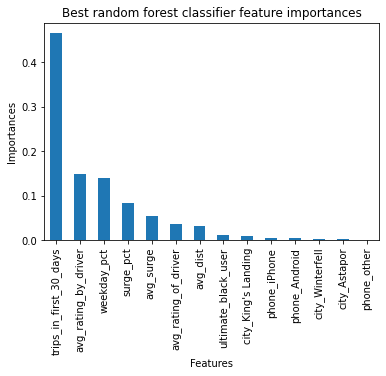

In [135]:
##########################################
# Feature importance
##########################################
pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).plot(kind='bar')
_=plt.xlabel('Features')
_=plt.ylabel('Importances')
_=plt.title('Best random forest classifier feature importances')
plt.show()

##### 3.2.2 XGBoost
eXtreme Gradient Boosting (XGBoost) is a scalable and improved version of the gradient boosting algorithm. XGBoost is one of the most popular machine learning algorithm these days.

In [6]:
##############################################
# Hyperparameter tuning by X_train, y_train
# 5-fold cross validation
##############################################
random.seed(3)
params=list(set([(
    random.sample([0.005, 0.01, 0.05, 0.1, 1, 10, 25, 50, 75, 100], 1)[0], # learning_rate 
    random.sample([10, 50, 100, 200, 500, 1000, 2000, 5000, 10000], 1)[0], # n_estimators 
    random.sample([2, 3, 4, 5, 6, 8, 10, 100, 500, 1000, None], 1)[0], # max_depth
    random.sample([0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1], 1)[0] # subsample
    ) for i in range(300)]))
len(params)

296

In [7]:
results=pd.DataFrame(columns=['params', 'accuracy', 'mean accuracy'])
for param in tqdm(params):
    try:
        learning_rate, n_estimators, max_depth, subsample=param
        accuracies=[]
        for train_index, test_index in kfold.split(X_train):
            X_train_train, X_train_test=X_train.iloc[train_index, :], X_train.iloc[test_index, :]
            y_train_train, y_train_test=y_train.iloc[train_index], y_train.iloc[test_index]
            model=xgb.XGBClassifier(objective='binary:logistic', 
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                subsample=subsample,
                                verbosity=0)
            model.fit(X_train_train, y_train_train)
            y_train_pred=model.predict(X_train_test)
            accuracies.append(accuracy_score(y_train_test, y_train_pred))
        results=results.append(pd.DataFrame({'params': [param], 
                                             'accuracy': [['{:.2f}'.format(ele) for ele in accuracies]], 
                               'mean accuracy': np.mean(accuracies)}))
    except:
        pass
results.sort_values(by=['mean accuracy'], ascending=False).head()

100%|██████████████████████████████████████████████████████████████████████████████| 296/296 [7:58:56<00:00, 97.08s/it]


,params,accuracy,mean accuracy
0,"(0.05, 1000, None, 0.9)","[0.95, 0.94, 0.94, 0.94, 0.94]",0.941340
0,"(0.01, 5000, None, 0.9)","[0.95, 0.95, 0.94, 0.94, 0.94]",0.941229
0,"(0.005, 10000, None, 0.9)","[0.95, 0.94, 0.94, 0.94, 0.94]",0.941173
0,"(0.005, 5000, 10, 0.75)","[0.94, 0.94, 0.93, 0.93, 0.94]",0.936012
0,"(0.01, 10000, 10, 1)","[0.94, 0.94, 0.93, 0.93, 0.94]",0.935957


In [8]:
#####################################################
# Use the best model on test data
#####################################################
xgboost_params=(0.05, 1000, None, 0.9)
learning_rate, n_estimators, max_depth, subsample=xgboost_params
model=xgb.XGBClassifier(objective='binary:logistic', 
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                subsample=subsample,
                                verbosity=0)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3848
           1       0.97      0.91      0.94      3875

    accuracy                           0.94      7723
   macro avg       0.94      0.94      0.94      7723
weighted avg       0.94      0.94      0.94      7723



In [9]:
cm=confusion_matrix(y_test, y_pred)
pd.DataFrame({' ': ['True Positive', 'False Negative', 'False Positive', 'True Negative'],
             'Count': [cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]]}).set_index(' ').T

,True Positive,False Negative,False Positive,True Negative
Count,3541,334,111,3737


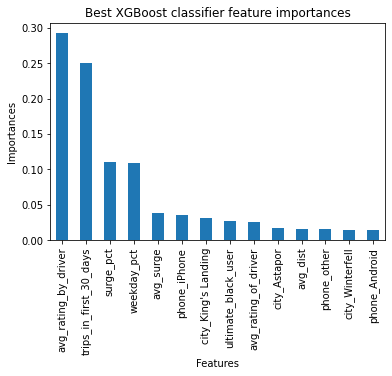

In [10]:
##########################################
# Feature importance
##########################################
pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).plot(kind='bar')
_=plt.xlabel('Features')
_=plt.ylabel('Importances')
_=plt.title('Best XGBoost classifier feature importances')
plt.show()

In [11]:
pd.DataFrame({' ': ['Random Forests', 'XGBoost'],
             'Accuracy': [0.91, 0.94]}).set_index(' ').T

,Random Forests,XGBoost
Accuracy,0.91,0.94


I use prediction accuracy as indicator of model performance. It seems that XGBoost exhibits higher prediction accuracy. Both models are good for prediction because 1) the accuracy of them is higher than 90%; and 2) the accuracy of each cross validation on the train set and the accuracy on the test set are close, which means there is no overfitting observed. I also considered using support vector machines (SVMs) and neural networks, but they are time-consuming. 

#### 3.3 Modeling Conclusion

Both Random Forests and XGBoost suggest that the top important features include average rating by driver, trips in the first 30 days, surge percentage, and weekday percentage. These are the best predictors for retention. 

Regarding the improvement of retentions of users, I have several suggestions:

1) Encourage drivers to rate users. The users who received more ratings, especially good ones, may like this platform more and would like to continue with this service.

2) Extend new user discount to at least 30 days. The users who used the service more times within the first 30 days would intend to stay in the service. A 30 day period may let many users form a habit of using this service.

3) Give better discount for surge service and weekday service. The users who used the service during surge or working days may more intend to form a habit of using this service, because the activities of these users are routine.

These suggestions may help Ultimate improve the user retention, and also improve the revenue.